<a href="https://colab.research.google.com/github/milesfking/NBA-Champion-Model/blob/main/Model%20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier

## Data Cleaning

In [10]:
# Load in dataset of previous seasons, include only teams who made the playoffs
dataset = pd.read_csv('nba_team_advanced_data.csv')
dataset = dataset[dataset["Playoffs"] == "Y"]

# Load in dataset of previous seasons, include only teams who made the playoffs
test_dataset = pd.read_csv('2023_advanced_data.csv')
test_dataset = test_dataset[test_dataset["Playoffs"] == "Y"]

# Drop irrelevant columns
dataset = dataset.drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])
test_dataset = test_dataset.drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])

# Split into predictor and response variables
X = dataset.iloc[:, ~ dataset.columns.isin(['Year', 'Champion', 'Team'])]
y = dataset.loc[:, dataset.columns == 'Champion'].values
y = np.array([0 if val == "N" else 1 for val in y])

X_test= test_dataset.iloc[:, ~ test_dataset.columns.isin(['Year', 'Champion', 'Team'])]
y_test = test_dataset.loc[:, test_dataset.columns == 'Champion'].values
y_test = np.array([0 if val == "N" else 1 for val in y_test])

# Transform data
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['won_last', 'won_last_3'])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
X_test = np.array(ct.transform(X_test))

# Scale data
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

## Logistic Regression

In [27]:
# Create logistic regression classifier
classifier = LogisticRegression(solver='lbfgs', random_state=0)
classifier.fit(X, y)

# Predict probabilities for test data
y_proba = classifier.predict_proba(X_test)

# Scale probabilities so they sum to 1
normalizing_const = sum([elem[1] for elem in y_proba])
y_proba = y_proba / normalizing_const

# Store predicted probabilities in DataFrame with team and year
team_names = test_dataset['Team'].values
year = test_dataset['Year'].values
predictions = pd.DataFrame(data=y_proba, columns=['Lose Probability', 'Win Probability'])
predictions.insert(loc=0, column='Team', value=team_names)
predictions.insert(loc=1, column='Year', value=year)

# Output DataFrame with team, year, and predicted probabilities
print("Model output:")
print(predictions.sort_values(by=['Win Probability'], ascending=False)[['Team', 'Win Probability']])

# Get the feature names after one-hot encoding
feature_names = ct.get_feature_names_out()

# Create a DataFrame to store coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': classifier.coef_.flatten() / normalizing_const})

# Print the coefficients
print()
print("Model coefficients:")
print(coefficients_df)

Model output:
                      Team  Win Probability
11         Milwaukee Bucks         0.410194
1           Boston Celtics         0.181999
6    Golden State Warriors         0.121528
5           Denver Nuggets         0.076651
4      Cleveland Cavaliers         0.044012
9        Memphis Grizzlies         0.040511
16      Philadelphia 76ers         0.027361
17            Phoenix Suns         0.021619
7     Los Angeles Clippers         0.014242
2            Brooklyn Nets         0.010615
14         New York Knicks         0.007825
3            Chicago Bulls         0.007798
18        Sacramento Kings         0.007623
8       Los Angeles Lakers         0.006692
13    New Orleans Pelicans         0.006010
12  Minnesota Timberwolves         0.005202
10              Miami Heat         0.003365
19         Toronto Raptors         0.003310
0            Atlanta Hawks         0.002354
15   Oklahoma City Thunder         0.001087

Model coefficients:
                  Feature  Coefficient
0 

## Cross Validation on Past Seasons

In [100]:
favorite = []
champion_probs = []

# Get a list of unique years in the dataset
years = dataset['Year'].unique()

# Get a list of champions in the dataset
champions = dataset[dataset['Champion'] == 'Y'][['Team', 'Year']]

# Iterate over the years
for year in years:
    print(f"Predicting for year {year}...")
    
    # Load test data for the current year
    test_dataset = dataset[dataset['Year'] == year]
    test_dataset = test_dataset[test_dataset["Playoffs"] == "Y"]

    # Drop irrelevant columns
    dataset_train = dataset[dataset['Year'] != year].drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])
    test_dataset = test_dataset.drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])

    # Split into predictor and response variables
    X_train = dataset_train.iloc[:, ~dataset_train.columns.isin(['Year', 'Champion', 'Team'])]
    y_train = dataset_train.loc[:, dataset_train.columns == 'Champion'].values
    y_train = np.array([0 if val == "N" else 1 for val in y_train])

    X_test = test_dataset.iloc[:, ~test_dataset.columns.isin(['Year', 'Champion', 'Team'])]
    y_test = test_dataset.loc[:, test_dataset.columns == 'Champion'].values
    y_test = np.array([0 if val == "N" else 1 for val in y_test])

    # Transform data
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['won_last', 'won_last_3'])], remainder='passthrough')
    X_train = np.array(ct.fit_transform(X_train))
    X_test = np.array(ct.transform(X_test))

    # Scale data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Create logistic regression classifier
    classifier = LogisticRegression(solver='lbfgs', random_state=0)
    classifier.fit(X_train, y_train)

    # Predict probabilities for test data
    y_proba = classifier.predict_proba(X_test)

    # Scale probabilities so they sum to 1
    normalizing_const = sum([elem[1] for elem in y_proba])
    y_proba = y_proba / normalizing_const

    # Store predicted probabilities in DataFrame with team and year
    team_names = test_dataset['Team'].values
    year_vec = test_dataset['Year'].values
    predictions = pd.DataFrame(data=y_proba, columns=['Lose Probability', 'Win Probability'])
    predictions.insert(loc=0, column='Team', value=team_names)
    predictions.insert(loc=1, column='Year', value=year_vec)

    # Output DataFrame with team, year, and predicted probabilities
    print("Model output:")
    sorted_probs = predictions.sort_values(by=['Win Probability'], ascending=False)[['Team', 'Win Probability']]
    print(sorted_probs.head())

    # Predicted versus true champion
    predicted_champion = sorted_probs['Team'].iloc[0]
    true_champion = champions[champions['Year'] == year]['Team'].iloc[0]
    print("Predicted Champion:", predicted_champion)
    print("True Champion:", true_champion)
    print()

    # Append champion probabilities
    champion_probs.append(predictions[predictions['Team'] == true_champion]['Win Probability'].iloc[0])

    # Get number of correct predictions
    if sorted_probs['Team'].iloc[0] == champions[champions['Year'] == year]['Team'].iloc[0]:
      favorite.append(1)
    else:
      favorite.append(0)

Predicting for year 1990.0...
Model output:
                      Team  Win Probability
5          Detroit Pistons         0.434010
8       Los Angeles Lakers         0.182904
13  Portland Trail Blazers         0.109709
14       San Antonio Spurs         0.046682
15               Utah Jazz         0.045731
Predicted Champion: Detroit Pistons
True Champion: Detroit Pistons

Predicting for year 1991.0...
Model output:
                      Team  Win Probability
12  Portland Trail Blazers         0.259600
2            Chicago Bulls         0.231335
1           Boston Celtics         0.128783
3          Detroit Pistons         0.123218
7       Los Angeles Lakers         0.094291
Predicted Champion: Portland Trail Blazers
True Champion: Chicago Bulls

Predicting for year 1992.0...
Model output:
                      Team  Win Probability
1            Chicago Bulls         0.676695
12  Portland Trail Blazers         0.098609
0           Boston Celtics         0.036095
10         New York Kni

## Analysis

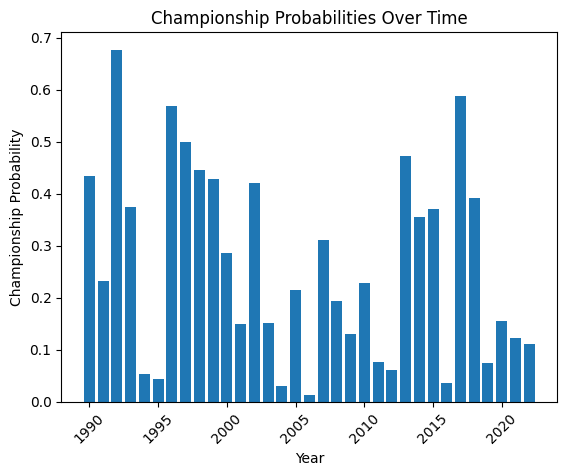

In [101]:
import matplotlib.pyplot as plt

plt.bar(years, champion_probs)
plt.xlabel('Year')
plt.ylabel('Championship Probability')
plt.title('Championship Probabilities Over Time')
plt.xticks(rotation=45)
plt.show()

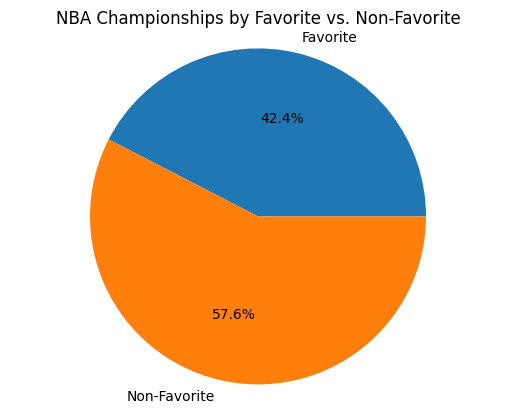

In [127]:
labels = ['Favorite', 'Non-Favorite']
favorite_count = [favorite.count(1), favorite.count(0)]

plt.pie(favorite_count, labels=labels, autopct='%1.1f%%')
plt.title('NBA Championships by Favorite vs. Non-Favorite')
plt.axis('equal')
plt.show()

In [125]:
print("Championship teams with less than a 10% chance to win the NBA Championship:")
for i in range(len(years)):
  if champion_probs[i] < 0.1:
    print(int(years[i]), list(champions['Team'])[i])

Championship teams with less than a 10% chance to win the NBA Championship:
1994 Houston Rockets
1995 Houston Rockets
2004 Detroit Pistons
2006 Miami Heat
2011 Dallas Mavericks
2012 Miami Heat
2016 Cleveland Cavaliers
2019 Toronto Raptors


In [126]:
print("Championship with greater than a 50% chance to win the NBA Championship:")
for i in range(len(years)):
  if champion_probs[i] > 0.5:
    print(int(years[i]), list(champions['Team'])[i])

Championship with greater than a 50% chance to win the NBA Championship:
1992 Chicago Bulls
1996 Chicago Bulls
2017 Golden State Warriors
